# Regresión Lineal en TensorFlow 2.0 con Keras
En regresión se predice la salida de un valor continuo como puede ser un precio o una probabilidad, a diferencia de clasificación donde el fin es seleccionar una clase de una lista de clases (por ejemplo si una fotografía incluye un objeto tal como una persona o un automovil).

Este ejemplo genera un modelo para predecir la eficiencia de combustible de automóviles de finales de 1970 a principios de 1980 por medio del dataset [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y genera un modelo para predecir la efiniciencoa de vehículos de finales de 1970 y principios de 1980.

Eete ejemplo utiliza el API [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)


In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [42]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [43]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## Dataset Autos MPG
Disponible en el [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)

### Obtener datos
Descarga de los datos desde una fuente externa por medio de `get_file`

In [44]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\Marciano\\.keras\\datasets\\auto-mpg.data'

Importar el dataset por medio de [pandas](https://pandas.pydata.org/docs/#)
pandas es una librería escrita para Python que provee de un lenguaje de programación para manipulación de datos. En particular ofrece estructuras de datos y operaciones para manipular tablas numéricas y series de datos.

In [45]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpiar los datos
Identificar instancias con valores faltantes.

In [46]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Eliminar columnas con valores faltantes.

In [47]:
dataset = dataset.dropna()

Convertir la columna Origin a categorica empleando one-hot encoding.

In [48]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))


In [49]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Segmentar los datos
Para entrenamiento y pruebas.

In [50]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspeccionar los datos
Obervar la distribución conjnuta de algunos pares de columnas del dataset de entrenamiento.

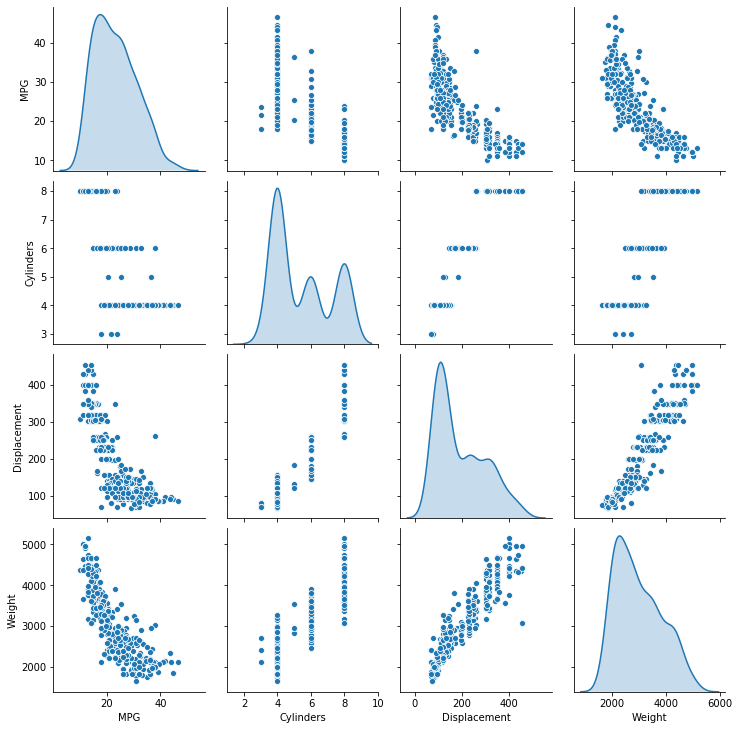

In [51]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Inspeccionar las estadísticas generales

In [52]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [53]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalizar los datos
El rango de las variables es distinto para cada una de las columnas. Para regresión se recomienda normalizar las características para simplificar el entrenamiento y reducir dependencias del modelo a ciertas variables.

Las estadísticas de normalización serán generadas a partir de los datos de entrenamiento y se aplicarán a los datos de pruebas para proyectar la misma distribución.

In [54]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Nota: Las estadísicas empleadas para normalizar las entradas deben ser aplicadas a cualquier otro dato que ingrese al modelo, junto con la codificación one-hot definida con anterioridad. Esto incluye al dataset de pruebas y datos no observados que ingresen en producción.

### Construir el modelo
Emplearemos un modelo `Sequential` con dos capas ocultas densamente conectadas y una capa de salida que regresa un solo valor continuo. Los pasos de contrucción del modelo se encuentran encapsulados en la función `build_model` para poder crear otros modelos posteriormente.

In [55]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [56]:
len(train_dataset.keys())

9

In [57]:
model = build_model()

### Inspeccionar el modelo
El método `.summary` despliega una descripción simple del modelo.

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Para probar el modelo se tomarán `10` ejemplos del dataset de entrenamiento y se invocará `model.predict`.

In [59]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.2543829 ],
       [ 0.06675182],
       [-0.41443306],
       [ 0.18663579],
       [ 0.10207682],
       [-0.02789782],
       [ 0.14157747],
       [ 0.12387487],
       [-0.06350806],
       [ 0.00339582]], dtype=float32)

### Entrenar el modelo
Entrenar el modelo 1,000 épocas y registrar la exactitud de entrenamiento y validación en el objeto `history`.

In [60]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:563.0389,  mae:22.4995,  mse:563.0389,  val_loss:550.1185,  val_mae:22.1604,  val_mse:550.1185,  
....................................................................................................
Epoch: 100, loss:6.1195,  mae:1.7455,  mse:6.1195,  val_loss:8.3253,  val_mae:2.2512,  val_mse:8.3253,  
....................................................................................................
Epoch: 200, loss:5.1833,  mae:1.5945,  mse:5.1833,  val_loss:8.6915,  val_mae:2.2916,  val_mse:8.6915,  
....................................................................................................
Epoch: 300, loss:4.8485,  mae:1.5175,  mse:4.8485,  val_loss:8.5922,  val_mae:2.2554,  val_mse:8.5922,  
....................................................................................................
Epoch: 400, loss:4.3002,  mae:1.4174,  mse:4.3002,  val_loss:9.0876,  val_mae:2.3398,  val_mse:9.0876,  
..............................................................

Visualizar el progreso del entrenamiento por medio de las estadísticas almacenadas en el objeto `history`.

In [61]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.583059,1.024522,2.583059,10.632249,2.452812,10.632249,995
996,2.411786,0.983458,2.411786,10.227997,2.365268,10.227998,996
997,2.422553,1.026333,2.422553,9.760136,2.351797,9.760136,997
998,2.337938,1.001490,2.337939,11.098860,2.576730,11.098861,998
999,2.402831,0.981491,2.402831,10.826254,2.547096,10.826253,999


In [62]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

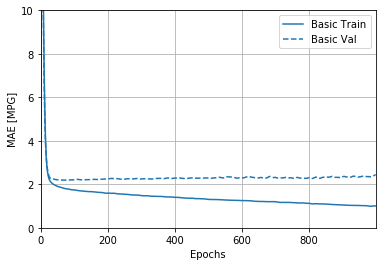

In [63]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

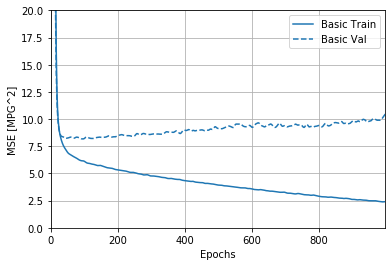

In [64]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

La gráfica de arriba muestra poca mejora, incluso degradación in el error de validación después de 100 épocas. Actualizaremos la llamada a `model.fit` para detener el entrenamiento automáticamente cuando la calificación de validación no mejore. Para ello emplearemos _Early stopping callback_ que prueba una condición de entrenamiento por cada época. Si una cantidad definida de épocas transcurre sin mejora, entonces el entrenamiento se detendrá automáticamente. Conoce más respecto a [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [65]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:564.2972,  mae:22.5107,  mse:564.2972,  val_loss:550.0043,  val_mae:22.1930,  val_mse:550.0043,  
............................................

Text(0, 0.5, 'MAE [MPG]')

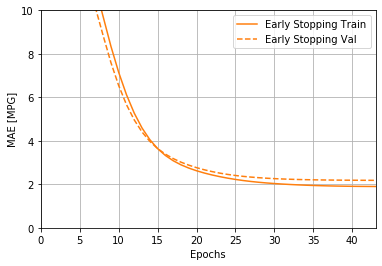

In [66]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Esta gráfica muestra que en el dataset de validación el error promedio es de +/- 2 MPG. 

Verificaremos cómo generaliza el modelo empleando el dataset de pruebas. Este nos indicará qué tan efectivo será el modelo en predecir en el mundo real. 

In [67]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.2642 - mae: 1.9346 - mse: 6.2642
Testing set Mean Abs Error:  1.93 MPG


### Hacer predicciones
Se predicirá MPG empleando datos de pruebas.

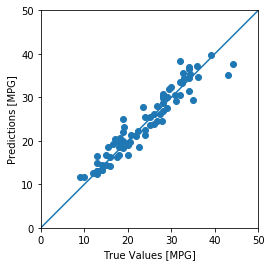

In [68]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Visualizaremos la distribución del error.

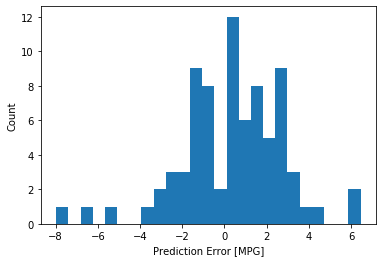

In [69]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

La distribución no es gausiana, debemos tomar en cuenta que el número de ejemplos fue muy bajo.

### Conceptos clave
- Mean Squared Error (MSE) es una función de pérdida (loss function) usual en problemas de regresión.
- Mean Absolute Error (MAE) es una métrica usual en problemas de regresión.
- Debemos aplicar normalización cuando las variables numéricas tengan distintos rangos.
- Cuando haya pocos datos de entrenamiento, es preferible tener una red pequeña un algunas capas ocultas para evitar sobreajustes.
- _Early stopping_ es una técnica útil para evitar sobreajustes.